In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import json
import pandas as pd
import numpy as np
import functools
import seaborn as sns
sns.set(style="whitegrid")
from pymongo import MongoClient

# Remember to connect to VPN first 
DATABASE_URL = "internal-mongo-elb-624130134.us-east-1.elb.amazonaws.com"
USER, PWD = 'analyzer', 'hyperpilot'
METRIC_DB, CONFIG_DB = 'metricdb', 'configdb'

In [2]:
# Utilities
def find_all(collection, filt={}, proj=None, database=METRIC_DB, return_list=False):
    """ A wrapper for 'find' to ensure the connection will be closed.
    Args:
        collection(str): mongoDB collection
        filt(dict): mongoDB filter
        proj(dict): mongoDB projection
        database(str): name of database
    Return:
        documents(cursor): mongoDB cursor 
    """
    try:
        client = MongoClient(DATABASE_URL, waitQueueTimeoutMS=200)
        db = client[database]
        db.authenticate(USER, PWD, source=database)
        if proj:
            documents = db[collection].find(filt, proj)
        else:
            documents = db[collection].find(filt)
    except Exception as e:
        raise e
    else:
        return documents if not return_list else list(documents)
    finally:
        client.close()


def find_one(collection, filt, proj=None, database=METRIC_DB):
    """ A wrapper for 'findOne' to ensure the connection will be closed.
    Args:
        collection(str): mongoDB collection
        filt(dict): mongoDB filter
        proj(dict): mongoDB projection
        database(str): name of database
    Return:
        documents(cursor): mongoDB cursor 
    """
    try:
        client = MongoClient(DATABASE_URL, waitQueueTimeoutMS=200)
        db = client[database]
        db.authenticate(USER, PWD, source=database)
        if proj:
            document = db[collection].find_one(filt, proj)
        else:
            document = db[collection].find_one(filt)
    except Exception as e:
        raise e
    else:
        return document
    finally:
        client.close()

In [3]:
def create_application_dataframe():
    app_objs = find_all(collection='applications', database=CONFIG_DB, return_list=True)
    data, columns = [], ['name', 'sloMetric', 'sloValue', 'sloType']
    for i in app_objs:
        data.append([i['name'], i['slo']['metric'], i['slo']['value'], i['slo']['type']])
    return pd.DataFrame(data, columns=columns)

In [86]:
def create_calibration_dataframe():
    cali_objs = find_all(collection='calibration', return_list=True)
    dfs = []
    keys = [set(i.keys()) for i in cali_objs]
    union_keys = functools.reduce(set.intersection, keys)
    union_keys.remove('testResult')

    for cali_obj in cali_objs:
        tmp_df = pd.read_json(json.dumps(cali_obj['testResult']))
        for i in union_keys:            
            tmp_df[i] = np.array(cali_obj[i]).squeeze()
        if 'qos' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'qos': 'qosValue'})
        if 'qosMetric' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'qosMetric': 'qosValue'})
        if 'intensity' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'intensity': 'loadIntensity'})
        dfs.append(tmp_df)
    cali_df = pd.concat(dfs)
    
    # make unique idx
    for i, j in cali_df.groupby(['appName', 'testId', 'qosMetrics']):
        df = pd.DataFrame(j)
        print i
        capacity = j['finalResult'].values[0]['qosValue']
        print("appName: {}, capacity: {}, qosMetric: {}".format(i[0], capacity, i[2]))
        df['idx'] = "appName: {}, sloValue: {}, sloType: {}".format(i[0], capacity, i[2])

        cali_df = cali_df.append(df)
    
    cali_df['failures'] = cali_df['failures'].apply(lambda x: 0. if x != x else x)
    return cali_df

In [16]:
def create_profiling_dataframe():
    prof_objs = find_all(collection='profiling', return_list=True)
    dfs = []
    keys = [set(i.keys()) for i in prof_objs]
    union_keys = functools.reduce(set.intersection, keys)
    print(union_keys)
    union_keys.remove('testResult')
    union_keys.remove('benchmarks')
    union_keys.remove('services')
    
    for prof_obj in prof_objs:
        tmp_df = pd.DataFrame([pd.Series(i) for i in prof_obj['testResult']])
        if 'toleratedInterference' in tmp_df.columns:
            del tmp_df['toleratedInterference']
        if 'qos' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'qos': 'qosValue'})
        if 'qosMetric' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'qosMetric': 'qosValue'})
        if 'intensity' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'intensity': 'loadIntensity'})
        for i in union_keys:
            if i == 'toleratedInterference':
                continue
            tmp_df[i] = np.array(prof_obj[i]).squeeze()
        # get zero intensity NOTE: assuming there is not collision
        z = find_one(collection='calibration', filt={'appName': prof_obj['appName']})['finalResult']['qosValue']
        for benchmark, df in tmp_df.groupby('benchmark'):
            row = pd.Series(df.iloc[0], copy=True)
            row['qosValue'], row['loadIntensity'] = z, 0
            tmp_df = tmp_df.append(row)
            tmp_df = tmp_df.sort_values(by='loadIntensity')
            dfs.append(tmp_df)
        
    df = pd.concat(dfs)
    
    return df

In [17]:
def computeToleratedInterference(benchmarks, sloMetric, metricType, tolerancePercentage=10.):
    """ Compute Tolerated Interference. 
    Assuming monotomicity in between each benchmarks interval. 
    Args: 
        benchmarks(DataFrame): index=loadIntensity and columns=['qosValue']
        sloMetric(float): service level objective for the application
        metricType(str): 'throughput', 'latency'
        tolerancePercentage(float): percentage of slo tolerance
    Return:
        ti(float): tolerated interference.
    """
    def _linearIntp(xy1, xy2, y3):
        x1, y1 = xy1
        x2, y2 = xy2
        if y1 > y2:
            return _linearIntp((x2,y2),(x1,y1), y3)
        if y3 < y1 or y3 > y2:
            return None
        else:
            return (y3-y1)*(x2-x1)/(y2-y1)+x1
        
    intensities, sloValues = np.append(0, benchmarks.index.values), np.append(sloMetric, benchmarks.values)
    candidates = []
    
    # check metric type
    if metricType == 'throughput':
        toleratedSloMetric = sloMetric * (1.-tolerancePercentage/100.)
        if min(sloValues) > toleratedSloMetric:
            candidates.append(100.)
    elif metricType == 'latency':
        toleratedSloMetric = sloMetric * (1.+tolerancePercentage/100.)
        if max(sloValues) < toleratedSloMetric:
            candidates.append(100.)
    else:
        assert False, 'invalid metric type'
    #print('type: {}'.format(metricType), 'toleratedMetric: {}'.format(toleratedSloMetric))

    # check input data
    assert (sorted(intensities) == intensities).all(), 'intensities are not monotonic. intensities: {}'.format(intensities)
    assert all(intensity >= 0 and intensity <= 100 for intensity in intensities), 'invalid intensities. intensites: {}'.format(intensities)
    assert len(sloValues) == len(intensities), 'length of sloValues and intensities does not match. sloValues: {}, intensities: {}'.format(sloValues, intensities)

    for i in range(len(sloValues)-1): # edge case tested
        x = _linearIntp((intensities[i], sloValues[i]), (intensities[i+1], sloValues[i+1]), toleratedSloMetric)
        if x:
            candidates.append(x)
    
    return sorted(candidates)

### configdb.application

In [18]:
app_df = create_application_dataframe()
app_df

,name,sloMetric,sloValue,sloType
0,redis,GET,35000.0,throughput
1,mongo,Insert.Empty,5000.0,throughput
2,mysql,95th_percentile,2.5,latency
3,kafka,99thLatency,500.0,latency
4,nginx,95,20.0,latency
5,goddd,95,400.0,latency


### metricdb.calibration

In [88]:
cali_df = create_calibration_dataframe()
cali_df.head(3)

(u'goddd', u'calibrate-260557f0-b398-4caa-74e6-e95a86d614fa', u'latency')
appName: goddd, capacity: 384.0, qosMetric: latency
(u'kafka', u'calibrate-09acc333-6247-403a-56da-780b95e7dcfe', u'latency')
appName: kafka, capacity: 456.0, qosMetric: latency
(u'mongo', u'calibrate-f2146884-8e2f-4318-5470-0dea61e558fe', u'throughput')
appName: mongo, capacity: 20000.0, qosMetric: throughput
(u'nginx', u'calibrate-fcc72fbc-c8ee-4fe9-5a81-beba5b218e07', u'throughput')
appName: nginx, capacity: 19.0, qosMetric: throughput
(u'redis', u'calibrate-ee9b6766-0205-4cdd-76e3-4263208944aa', u'throughput')
appName: redis, capacity: 57085.85, qosMetric: throughput


,_id,appName,failures,finalResult,idx,loadIntensity,loadTester,qosMetrics,qosValue,testDuration,testId
0,5959ae1ce3fd9e5094de6697,mongo,0.0,"{u'loadIntensity': 13.0, u'qosValue': 20000.0}",NaN,1,mongo-bench,throughput,409.439159,36m44.999831586s,calibrate-f2146884-8e2f-4318-5470-0dea61e558fe
1,5959ae1ce3fd9e5094de6697,mongo,0.0,"{u'loadIntensity': 13.0, u'qosValue': 20000.0}",NaN,1,mongo-bench,throughput,474.437198,36m44.999831586s,calibrate-f2146884-8e2f-4318-5470-0dea61e558fe
2,5959ae1ce3fd9e5094de6697,mongo,0.0,"{u'loadIntensity': 13.0, u'qosValue': 20000.0}",NaN,1,mongo-bench,throughput,441.137242,36m44.999831586s,calibrate-f2146884-8e2f-4318-5470-0dea61e558fe


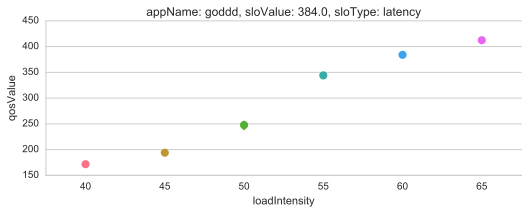

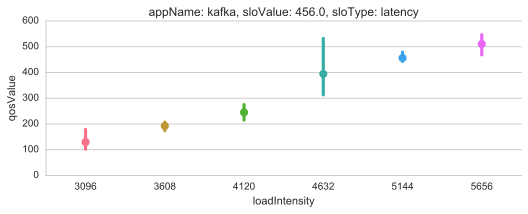

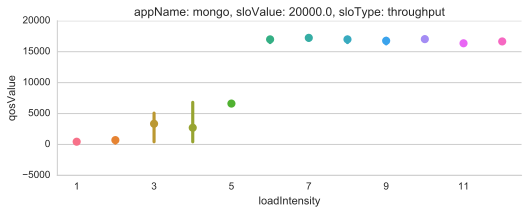

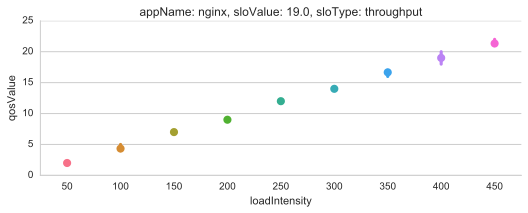

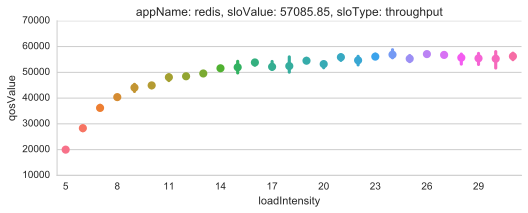

In [89]:
for i, j in cali_df.groupby('idx'):
    g = sns.factorplot(x="loadIntensity", y="qosValue", hue=None, data=j, palette="husl", ci=100, kind='point',
                       sharex=False, sharey=False, alpha=0.9, size=3, scale=0.8, aspect=2.5)
    for ax in g.fig.get_axes():
        ax.locator_params(nbins=10, axis='x')
    plt.title(i)    

### metricdb.profiling

In [87]:
prof_df = create_profiling_dataframe()
prof_df.head(3)

set([u'serviceInTest', u'testResult', u'appName', u'testDuration', u'sloTolerance', u'numServices', u'toleratedInterference', u'appCapacity', u'loadTester', u'testId', u'benchmarks', u'services', u'serviceNode', u'_id', u'sloMetric'])


,benchmark,failures,loadIntensity,qosValue,serviceInTest,appName,testDuration,sloTolerance,numServices,appCapacity,loadTester,testId,serviceNode,_id,sloMetric
0,cpu,0,0,57085.85,redis-serve,redis,,0.0,1,68.0,redis-bench,benchmark-579bb43c-cf1e-4eb1-4a9b-2e7bc298ec91,,59606286e3fd9e5094deb389,GET
52,memCap,0,10,49694.38,redis-serve,redis,,0.0,1,68.0,redis-bench,benchmark-579bb43c-cf1e-4eb1-4a9b-2e7bc298ec91,,59606286e3fd9e5094deb389,GET
53,memCap,0,10,50198.29,redis-serve,redis,,0.0,1,68.0,redis-bench,benchmark-579bb43c-cf1e-4eb1-4a9b-2e7bc298ec91,,59606286e3fd9e5094deb389,GET


### Inspect each appName, serviceInTest individually

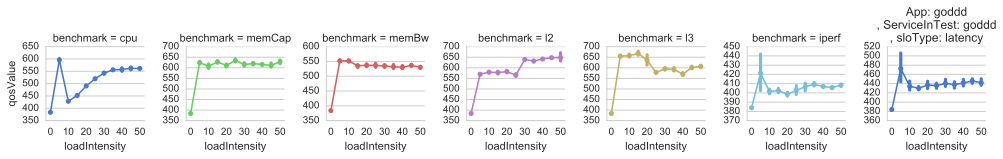

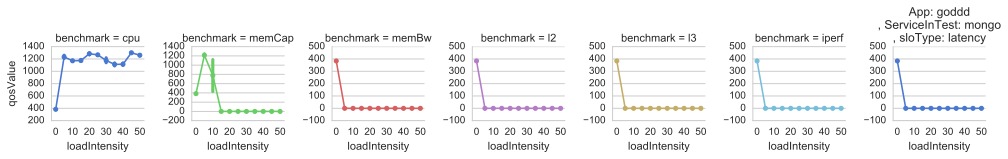

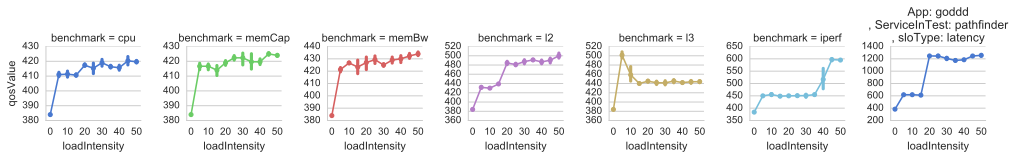

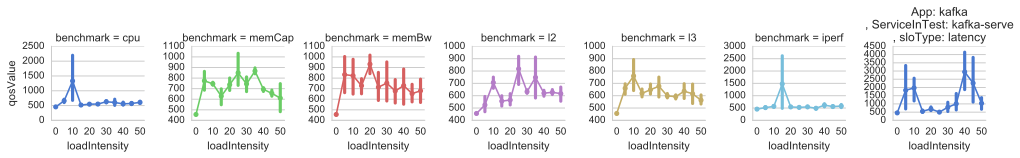

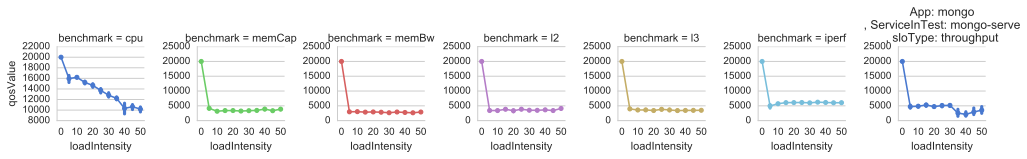

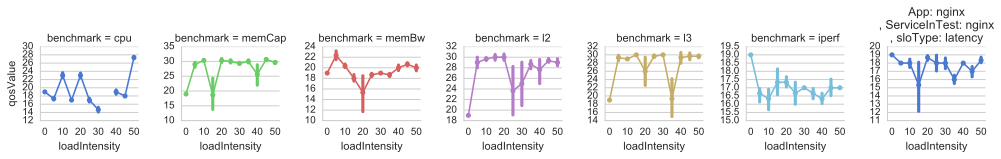

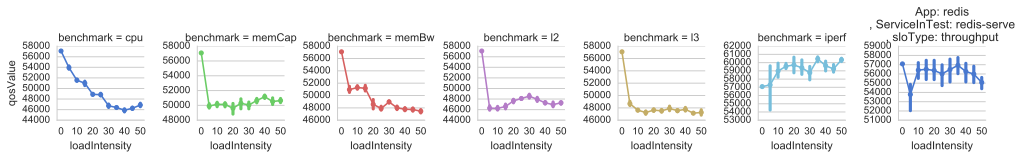

In [105]:
for appName, df in prof_df.groupby(['appName', 'serviceInTest']):
    g = sns.factorplot(x="loadIntensity", y="qosValue", col="benchmark",
                       hue="benchmark", data=df, ci=100, palette="muted", size=2, scale=0.5,
                       scatter_kws={"s": 50, "alpha": 0.5}, sharey=False)
    sloType = app_df[app_df['name'] == appName[0]]['sloType'].values[0]
    plt.title("App: {}\n, ServiceInTest: {}\n, sloType: {}".format(appName[0], appName[1], sloType))
    for ax in g.fig.get_axes():
        ax.locator_params(nbins=10, axis='x')

### Generate radar plot

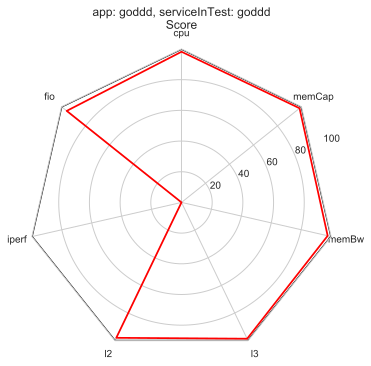

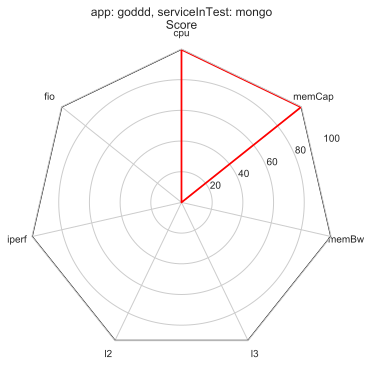

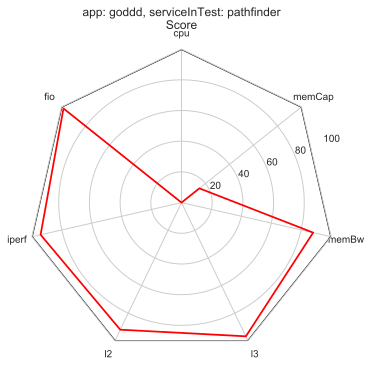

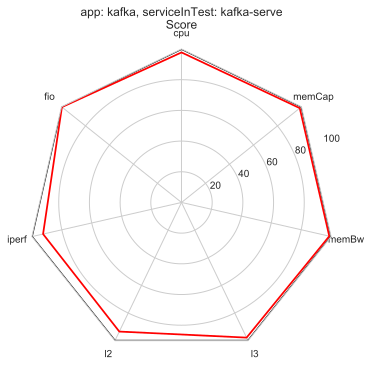

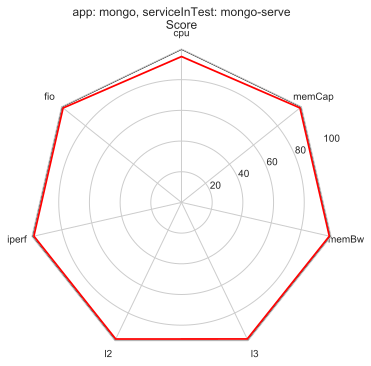

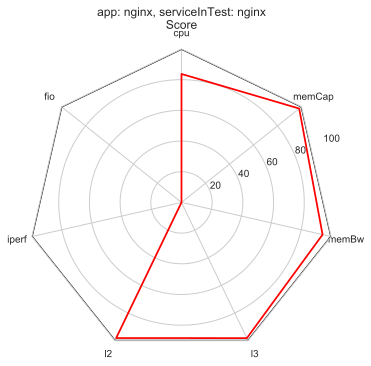

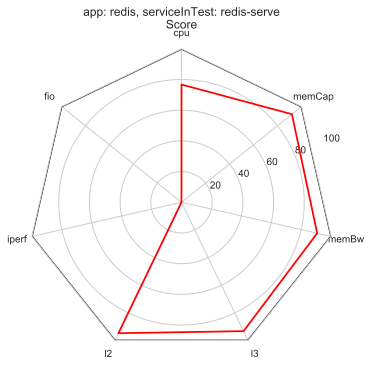

In [101]:
from radar import radar_graph

for (app, serviceInTest), df in prof_df.groupby(['appName', 'serviceInTest']):
    sloValue = find_one(collection='calibration', filt={'appName': app})['finalResult']['qosValue']
    metricType = find_one(database=CONFIG_DB, collection='applications', filt={'name': app})['slo']['type']

    radar_data = {}
    radar_data['benchmark'] = []
    radar_data['tolerated_interference'] = []
    for benchmark, df2 in df.groupby(['benchmark', 'loadIntensity'])['qosValue'].agg("mean").groupby(level=0):
        df2.index = df2.index.droplevel(level=0)
        result = computeToleratedInterference(df2, sloValue, metricType=metricType)
        radar_data['benchmark'].append(benchmark)
        radar_data['tolerated_interference'].append(min(result))
    
    labels = radar_data['benchmark']
    values = radar_data['tolerated_interference']
    scores = 100. - np.array(values)
    radar_graph(labels, [100]*len(values), scores)
    plt.title("app: {}, serviceInTest: {}\nScore".format(app, serviceInTest))
    plt.show()